# IMGEP-MUGL

This notebook is a companion to the paper [Curiosity Driven Exploration of Learned Disentangled Goal Spaces](https://arxiv.org/abs/1807.01521). It contains a worked example of the algorithm presented in the paper. 

In [1]:
import numpy as np
import scipy.stats

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from latentgoalexplo.actors import exploactors
from latentgoalexplo.environments import armballs
from latentgoalexplo.representation import representation_pytorch

In [2]:
def discretized_entropy(X_s, n_bins=30):
    n_samples, n_dim = X_s.shape
    histp, _ = np.histogramdd(X_s, bins=n_bins, range=np.array([[-1] * n_dim, [1] * n_dim]).T)
    histp = histp.ravel() / histp.sum()
    return scipy.stats.entropy(histp)

def nb_explored_cells(X_s, n_bins=30):
    n_samples, n_dim = X_s.shape
    histp, _ = np.histogramdd(X_s, bins=n_bins, range=np.array([[-1] * n_dim, [1] * n_dim]).T)
    return len(np.where(histp>0)[0])

# The Arm Balls Environment

This environment is composed of a seven joints robotic arm (the agent) and two balls:
+ One of the ball can be grasped by the robotic arm and moved in the scene (the yellow one below). 
+ The other ball (the blue one) cannot be moved by the robotic arm and follows a random walk in the environment. 

The robotic arm motion is parameterized by a controller defined using radial basis function. A movement of the arm is bounded to 50 timesteps; so is a roll out in the environment. Below we show an example of a motion produced by the controller. 

The object size control how simple it is for the arm to catch the yellow ball. Note that the ball size (used in the simulation computation) does not affect its rendered size, which could change the way the representation is learned. 

<IPython.core.display.Javascript object>


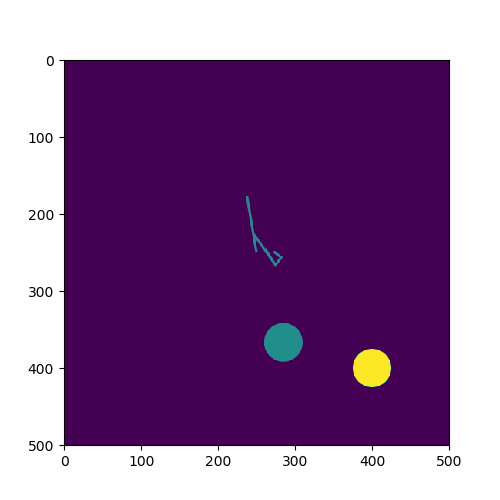

In [4]:
# We instantiate the environment
a = armballs.MyArmBalls(arm_lengths=np.array([0.3, 0.2, 0.2, 0.1, 0.1, 0.05, 0.05]), object_size=0.1,
                        distract_size=0.1, distract_noise=0.1, n_rbf=7, sdev=10., n_timesteps=50, render=True)
# We reset it
a.reset()
# We perform a random motor command
a.act(np.random.randn(len(a.action_space)))

As opposed to many environments considered in reinforcement learning, there is no pre-defined _reward_, nor is there a particular task to be fulfilled by the agent. In this case, our goal is to devise an exploration algorithm which is able to autonomously learn actions that produce the most diverse outcomes. 

In ArmBalls, we know as an experimenter, that the only way the agent can modify its environment in a repeatable way, is to catch the yellow ball and drag it to another place (since only the yellow ball can be moved). Consequently, we would like our algorithm to be able to put the yellow ball in as many different locations as possible.

# A naïve approach: Random Parameterization Exploration

The first approach one could think of to explore the environment, is to pick a random parameterization of the agent controller at each epoch. This is the most naive exploration scheme that one can perform since it doesn't use any previous action/outcome pair to chose the next action.

Below we show an example of 20 epochs of such a Random Parameterization Exploration. 

In [5]:
# Configuration for environment
env_config = dict()
env_config.update({'arm_lengths': np.array([0.3, 0.2, 0.2, 0.1, 0.1, 0.05, 0.05]),
                   'object_size': 0.1, 'distract_size': 0.1, 'distract_noise': 0.1,
                   'n_rbf': 7, 'sdev': 10, 'n_timesteps': 50, 'render_arm': False,
                   'width': 64, 'height': 64, 'render': True})

<IPython.core.display.Javascript object>


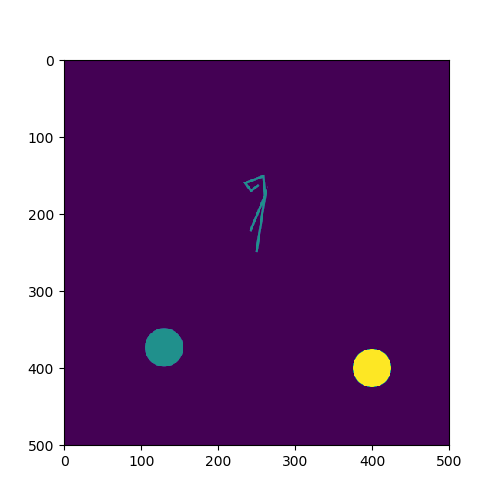

In [6]:
# Random Parameterization Experiment
n_exploration_iterations = 20
a = exploactors.RandomParameterizationExploration(static_env=armballs.MyArmBalls, **env_config)
a.reset()
a.act(n_iter=n_exploration_iterations, render=True)

We can see that the ball does not seem to be caught very often. Let's do more iterations and plot every end positions of the ball: 

<IPython.core.display.Javascript object>


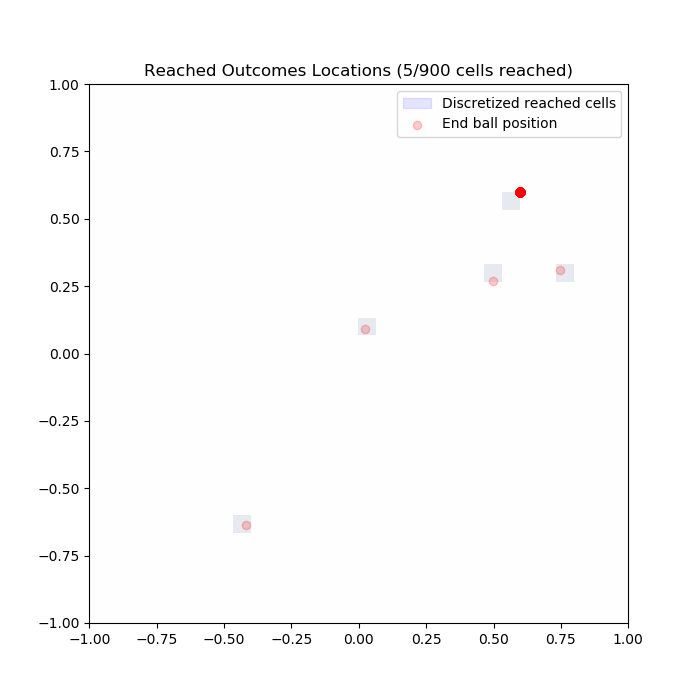

In [7]:
# Random Parameterization Experiment
n_exploration_iterations = 200
env_config_n = env_config.copy()
env_config_n.update({'render':False})
a = exploactors.RandomParameterizationExploration(static_env=armballs.MyArmBalls, **env_config_n)
a.reset()
a.act(n_iter=n_exploration_iterations, render=False)
# We compute the number of explored cells by the yellow ball in a grid of 30 x 30 cells
explo = nb_explored_cells(np.array(a.outcomes_states), n_bins=30)
# We scatter plot of the outcomes reached
outcomes = np.array(a.outcomes_states)
hist = np.histogramdd(outcomes, 30, ((-1,1), (-1,1)))[0].astype(np.bool)
hist = np.rot90(hist)
plt.figure(figsize=(7,7))
plt.imshow(hist, extent=(-1,1,-1,1), alpha=.1, cmap="Blues")
scat = plt.scatter(outcomes[:, 0], outcomes[:, 1], alpha=.2, color='red', label="End ball position")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
cells_legend = mpatches.Patch(color='blue', label="Discretized reached cells", alpha=.1)
plt.legend(handles=[cells_legend, scat])
plt.title("Reached Outcomes Locations ({}/{} cells reached)".format(explo, 30**2));

One way to compare the exploration of different algorithms is to discretize the outcome space and count the number of cells reached by the algorithm. On this figure, we represented the reached ball positions in red, and the subsequent reached cells in light blue. We observe that the robotic arm does not grab the ball in most roll-outs, the reason why it has remained in the initial position (the msot red one). 

One could argue that asymptotically, if we disregard the cases when the ball has not been reached, a great diversity of outcomes could be produced. Problem is, in most robotic setups, experiments are costly, and one could not spend an infinite amount of roll outs to learn an inverse model. In this situation we can not afford to waste a large part of our experiment budget in performing the wrong experiments. In fact, in the ArmBalls environment, RPE is a terrible strategy since the probability to catch the ball by when performing a random action is around 0.01. This means that 99% of the experiments are somehow wasted. 

# Intrinsically Motivated Goal Exploration Processes 

In our paper we use Intrinsically Motivated Goal Exploration Processes (see paper for details) to perform exploration. These algorithms were shown to be efficient to explore unknown environments. The idea of IMGEPs is to perform a goal exploration. At each iterations: 
1. The agent samples a goal that it will try to fullfil (e.g. a end position of the ball)
2. It then performs an experiment using a motor command that gave the closest outcome in past experiments (according to a certain model)
3. It then adds an exploration noise to this motor command before performing it. 

This strategy is efficient because it allows the agent to sample more often motor commands which have had an impact on the environment. Until now, those algorithms were often implemented on enviroments where the the true states of each objects (x and y positions of the two balls) was available (or extracted by a third-party program). The downside of this approach is that it does not scale well to large goal spaces, e.g. if only images of the environment are observed.

# Modular Unsupervised Goal-Space Learning

In our paper we proposed an architecture for modular goal exploration when the sensori space is high dimensional (e.g. in the case of images). The general idea is to:
1. Learn a representation of the environment using a representation algorithm (typically a variationnal auto-encoder (VAE)).
2. Define modules which consist of a subset of some latent variables (for example module 1 could correspond to latent 0 and latent 5).
3. Use those modules as goal-space for an IMGEP algorithm.

Using this algorithm, the agent can chose to set a goal in one of the modules, for example a goal could correspond to achieving a final image for which the encoding latents of module 2 have a certain value. The main interest of this modular approach is that it allows to use an _active_ goal sampling scheme: 
1. Select a module based on an _interest measure_
2. Sample a goal in this module randomly.

In practice, the modules are created by grouping together latents which have the same Kullback Leibler divergence. 

Below, we perform a modular goal exploration on a learned goal space in the ArmBalls environment. The goal space is learned using a $\beta$-VAE. Two different representations can be used as a goal space during the exploration:
+ One disentangled (large $\beta$)
+ One entangled (standard VAE, $\beta = 1$).

In [10]:
training_images.shape

(1000, 64, 64, 3)

In [8]:
# MGE Vae experiment
n_bootstrap = 400
n_exploration_iterations = 1600
# Disentangled representation
model_path = '../weights/ArmBalls_rgb_BallDistract'
# Entangled representation
# model_path = '../weights/ArmBalls_rgb_BallDistract_ent'


# We observe the ball moving (probably a scientist showing the position the ball can take)
# Used here to estimate KLD for each latents in order to create learning modules
a = armballs.ArmBallsRenderer(**env_config_n)
a.reset()
training_images = []
for i in range(1000):
    state = np.random.uniform(-1, 1, a.action_space.shape[0])
    a.act(observation=state)
    training_images.append(a.rendering)
training_images = np.array(training_images)

# We perform Bootstrap
a = exploactors.RandomParameterizationExploration(static_env=armballs.MyArmBallsObserved, **env_config_n)
a.reset()
a.act(n_iter=n_bootstrap, render=False)

# We perform AGE-UGL
b = exploactors.ActiveGoalExplorationUgl(static_env=armballs.MyArmBallsObserved,
                                         representation=representation_pytorch.PytorchBetaVAERepresentation,
                                         n_latents=10, beta=1, initial_epochs=0,
                                         interest_model='normal', n_explore=4, explo_ratio=0.1,
                                         n_modules=5, explo_noise_sdev=0.05, win_size=1000, **env_config_n)
b.load_representation(actions=a.actions, outcomes=a.outcomes, outcomes_states=a.outcomes_states,
                      outcomes_train=training_images, model_path=model_path)
b.act(n_iter=n_exploration_iterations, render=render)

ValueError: axes don't match array

<IPython.core.display.Javascript object>


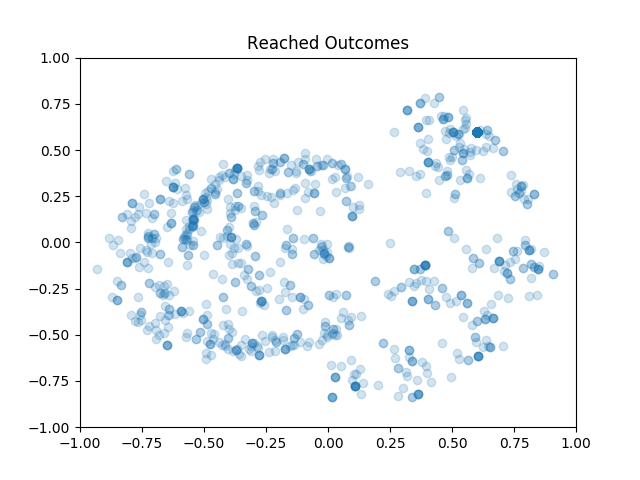

Text(0.5,1,'Reached Outcomes')

In [84]:
# We compute the number of explored cells by the yellow ball in a grid of 30 x 30 cells
explo = nb_explored_cells(np.array(a.outcomes_states), n_bins=30)
# We scatter plot of the outcomes reached
outcomes = np.array(a.outcomes_states)
hist = np.histogramdd(outcomes, 30, ((-1,1), (-1,1)))[0].astype(np.bool)
hist = np.rot90(hist)
plt.figure(figsize=(7,7))
plt.imshow(hist, extent=(-1,1,-1,1), alpha=.1, cmap="Blues")
scat = plt.scatter(outcomes[:, 0], outcomes[:, 1], alpha=.2, color='red', label="End ball position")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
cells_legend = mpatches.Patch(color='blue', label="Discretized reached cells", alpha=.1)
plt.legend(handles=[cells_legend, scat])
plt.title("Reached Outcomes Locations ({} cells reached)".format(explo));

We see that the number of visited cells is much larger than in the random parameterization case. Actually, one can show (see paper for details) that the exploration power using this architecture is in fact as good as when using the true state of the system (x and y positions of the ball that can be grasped).

We can also take a look at the interest measures of the agent for each of the modules defined by the algorithm: 

<IPython.core.display.Javascript object>


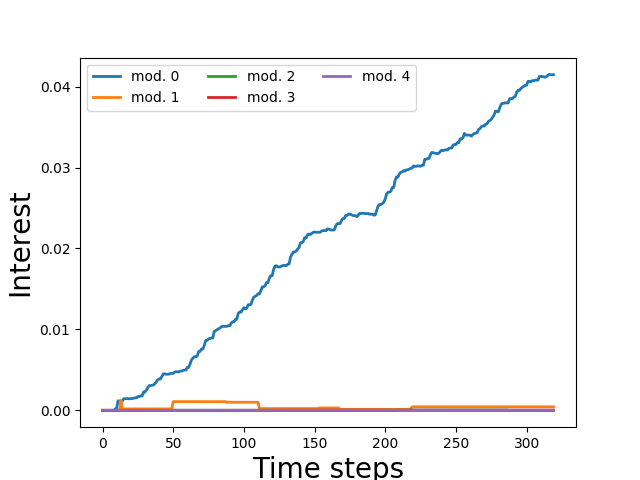

Text(0,0.5,'Interest')

In [86]:
fig, ax = plt.subplots()
ax.plot(b.interests_evolution, lw=2)
ax.legend(["mod. 0", "mod. 1", "mod. 2", "mod. 3", "mod. 4", "mod. 5"], ncol=3)
ax.set_xlabel('Time steps', fontsize=20)
ax.set_ylabel('Interest', fontsize=20)

It shows that when the representation is disentangled the interest is high only for module 0; the module corresponding to the yellow ball that can be grasped. In one way, the agent has learned which latent variables can be controlled. This knowledge can later be reused in another algorithm.